In [4]:
from itertools import product
import multiprocessing

import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.sparse as sp
import numpy as np

from fairpair import *

In [2]:
from accuracy_workers import *

## Export Graphs

In [4]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [8]:
sampler = RandomSampling(G, warn=False)
ranker = RankRecovery(G)
path = './data/GNNRank_networks/'

for j in range(101):
    sampler.apply(iter=10, k=1)
    if nx.is_strongly_connected(G): # only apply ranking recovery if strongly connected
        adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
        nodes = np.array(G.nodes)
        sp.save_npz(f'{path}random_iter{j*10}_adj', adj)
        np.save(f'{path}random_iter{j*10}_node_list', nodes)

## Read Results

In [3]:
path = './data/GNNRank_results/'
ranking = np.load(f'{path}DIGRACinnerproduct_pred0.npy')

In [ ]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], data['bias'], data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])

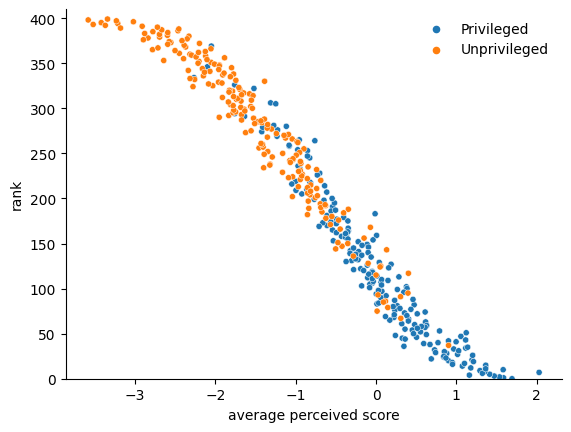

In [14]:
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Integrated Evaluation

In [1]:
import torch

import sys
sys.path.append('../GNNRank/') # also add the path to Pylance in VSCode settings: python.analysis.extraPaths

from src.param_parser import ArgsNamespace # just import the class, not the parser
from src.metrics import print_performance_mean_std
from src.Trainer import Trainer

In [39]:
# Instead of parsing, set all arguments directly
# Carefully check if the settings are actually possible!
args = ArgsNamespace(AllTrain=True, ERO_style='uniform', F=70, Fiedler_layer_num=5, K=20, N=350, SavePred=False, all_methods=['DIGRAC', 'ib'],
                     alpha=1.0, baseline='syncRank', cuda=True, data_path='/home/jovyan/GNNRank/src/../data/', dataset='fairPair_test/',
                     debug=False, device=torch.device(type='cuda'), dropout=0.5, early_stopping=200, epochs=1000, eta=0.1, fill_val=0.5, hidden=8, hop=2,
                     load_only=False, log_root='/home/jovyan/GNNRank/src/../logs/', lr=0.01, no_cuda=False, num_trials=1, optimizer='Adam', p=0.05,
                     pretrain_epochs=50, pretrain_with='dist', regenerate_data=True, season=1990, seed=31, seeds=[10], sigma=1.0, tau=0.5, test_ratio=1,
                     train_ratio=1, train_with='dist', trainable_alpha=False, upset_margin=0.01, upset_margin_coeff=1.0, upset_ratio_coeff=1.0, weight_decay=0.0005)
torch.manual_seed(args.seed)
device = args.device

In [40]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [41]:
sampler = RandomSampling(G, warn=False)
sampler.apply(iter=500, k=1)

In [42]:
adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix

Generating new data or new data splits!
loaded test_mask: None


In [43]:
save_path_best, save_path_latest = trainer.train(model_name='DIGRAC')

  0%|          | 0/1000 [00:00<?, ?epochs/s]

In [44]:
adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
score, pred_label = trainer.predict_nn(model_name='DIGRAC', model_path=save_path_best, A=adj, GNN_variant='dist')
ranking = {key: 1-score for key, score in enumerate(score.cpu().detach().numpy())}

In [45]:
weighted_tau(G, ranking)

0.33330709224578714

In [46]:
ranker = RankRecovery(G)
ranking2, other_nodes = ranker.apply()
weighted_tau(G, ranking2)

0.30898795368461807

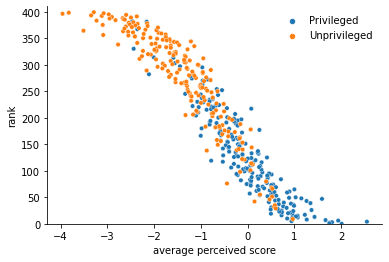

In [47]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()